## [MultiVariate Gaussian Guide](http://pyro.ai/examples/intro_long.html#Introduction-to-Pyro)

In [ ]:
%reset -s -f

In [1]:
import logging
import os

In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pyro

In [4]:
assert pyro.__version__.startswith('1.8')

In [5]:
pyro.enable_validation(True)
pyro.set_rng_seed(234)

In [6]:
logging.basicConfig(format='%(message)s', level=logging.INFO)

In [7]:
%matplotlib inline
plt.style.use(style='ggplot')

___

___

In [8]:
train = torch.load("pyro01.pt")

In [9]:
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 3]

Probabilistic models in Pyro are specified as Python functions model(*args, **kwargs) that generate observed data from latent variables using special primitive functions whose behavior can be changed by Pyro’s internals depending on the high-level computation being performed.

Specifically, the different mathematical pieces of model() are encoded via the mapping:

1. latent random variables $z \Longleftrightarrow$  pyro.sample

2. observed random variables $y \Longleftrightarrow$  pyro.sample with the obs keyword argument

3. learnable parameters $\theta \Longleftrightarrow$  pyro.param

4. plates $\Longleftrightarrow$ pyro.plate context managers

In [10]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

### Bayesian Model

In [11]:
def reg_model(is_cont_africa, ruggedness, log_gdp=None):
    alpha = pyro.sample('alpha', dist.Normal(0., 10))
    beta_A = pyro.sample("beta_a", dist.Normal(0., 1))
    beta_R = pyro.sample("beta_r", dist.Normal(0., 1))
    beta_AR = pyro.sample("beta_ar", dist.Normal(0., 1))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10))

    mu = alpha + beta_A * is_cont_africa + beta_R * ruggedness + beta_AR * is_cont_africa * ruggedness

    with pyro.plate("observations", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mu, sigma), obs=log_gdp)

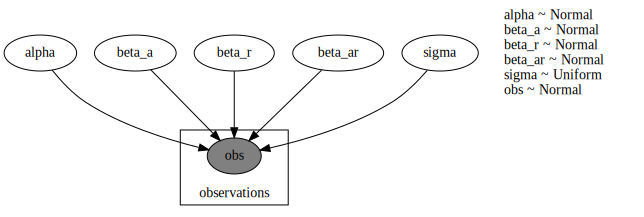

In [12]:
pyro.render_model(
                    reg_model, 
                    model_args=(is_cont_africa, ruggedness, log_gdp), 
                    render_distributions=True, 
                    render_params=True
                    )

To improve our results, we will try using a guide that generates samples from a multivariate normal distribution over all parameters. This allows us to capture the correlations between the latent variables via a full-rank covariance matrix $\Sigma \in \mathbb{R}^{5 \times 5}$ our previous guide ignored these correlations. That is, we have



$$\alpha, \beta_a, \beta_r, \beta_{ar}, \sigma_u \sim q_{\phi = ({\bf \mu}, {\bf \Sigma})}(\alpha, \beta_a, \beta_r, \beta_{ar}, \sigma_u) = \rm{Normal}((\alpha, \beta_a, \beta_r, \beta_{ar}, \sigma_u) | {\bf \mu}, {\bf \Sigma})$$

$$\sigma = \rm{constrain}(\sigma_u)$$

In [13]:
mvg_guide = pyro.infer.autoguide.AutoMultivariateNormal(reg_model)

In [26]:
%%time

pyro.clear_param_store()

#auto_guide = pyro.infer.autoguide.AutoNormal(reg_model)


adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()

svi = pyro.infer.SVI(reg_model, mvg_guide, adam, elbo)

losses = []

for step in range(2000):
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 ==0:
        logging.info("Elbo loss is {}".format(loss))

Elbo loss is 454.97291231155396
Elbo loss is 394.3457968235016
Elbo loss is 287.44088965654373
Elbo loss is 246.14710646867752
Elbo loss is 247.44548827409744
Elbo loss is 245.19125366210938
Elbo loss is 248.68746507167816
Elbo loss is 248.83872520923615
Elbo loss is 247.22928071022034
Elbo loss is 249.28722548484802
Elbo loss is 247.59487360715866
Elbo loss is 248.62081909179688
Elbo loss is 247.98273301124573
Elbo loss is 247.0822412967682
Elbo loss is 248.32079833745956
Elbo loss is 248.3866685628891
Elbo loss is 247.53509891033173
Elbo loss is 249.02331733703613
Elbo loss is 246.66969501972198
Elbo loss is 247.5688922405243
Elbo loss is 247.7345054745674
Elbo loss is 248.0665939450264
Elbo loss is 248.2145358324051
Elbo loss is 248.04917335510254
Elbo loss is 248.59533262252808
Elbo loss is 246.2699435353279
Elbo loss is 248.39915162324905
Elbo loss is 248.25561320781708
Elbo loss is 246.94138103723526
Elbo loss is 248.4374254345894
Elbo loss is 248.095130443573
Elbo loss is 247.12

CPU times: user 1min 5s, sys: 528 ms, total: 1min 5s
Wall time: 43.6 s


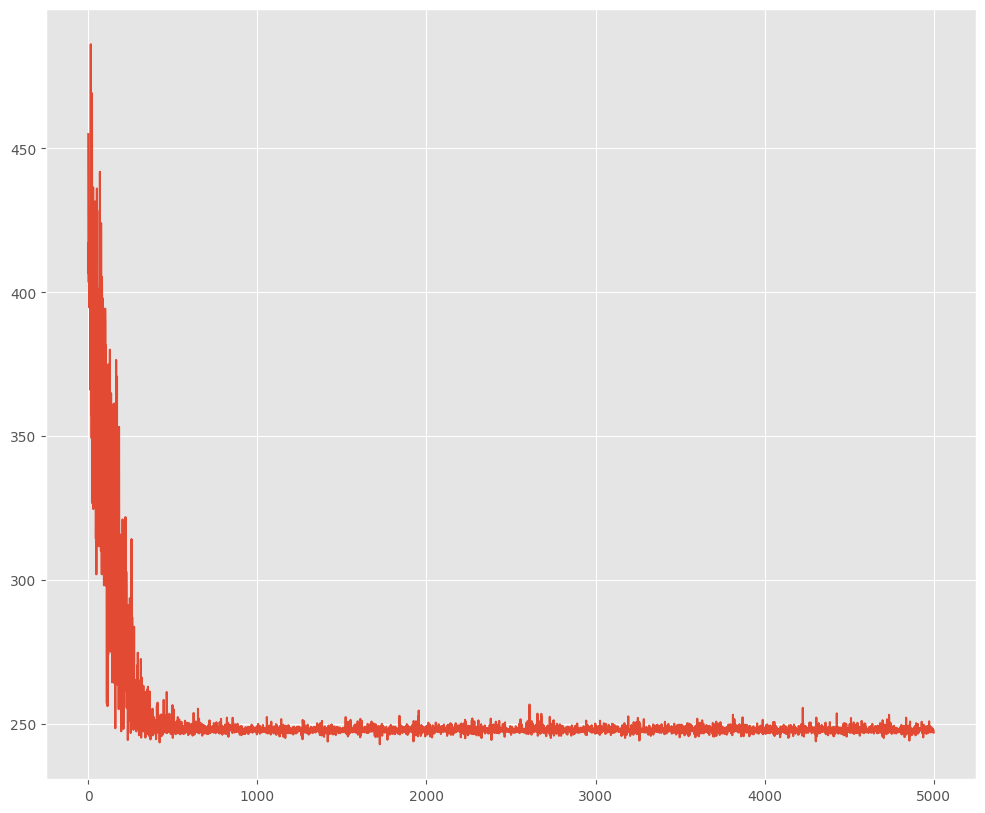

In [27]:
plt.figure(figsize=(12,10))
plt.plot(losses)

In [28]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoMultivariateNormal.scale [0.13332208 0.1856953  0.0458342  0.07399701 0.06107566]
AutoMultivariateNormal.scale_tril [[ 1.          0.          0.          0.          0.        ]
 [-0.83101785  1.          0.          0.          0.        ]
 [-1.3286229  -0.0816708   1.          0.          0.        ]
 [ 0.516052   -0.92532617 -0.5859556   1.          0.        ]
 [-0.05695805  0.0806547   0.07267125  0.0334467   1.        ]]
AutoMultivariateNormal.loc [ 9.190409   -1.8285221  -0.17275055  0.3251867  -2.260566  ]


In [29]:
with pyro.plate("samples", 800, dim=-1):
    samples = mvg_guide(is_cont_africa, ruggedness)

In [30]:
gamma_within_africa = samples['beta_r'] + samples['beta_ar']
gamma_outside_africa = samples['beta_r']

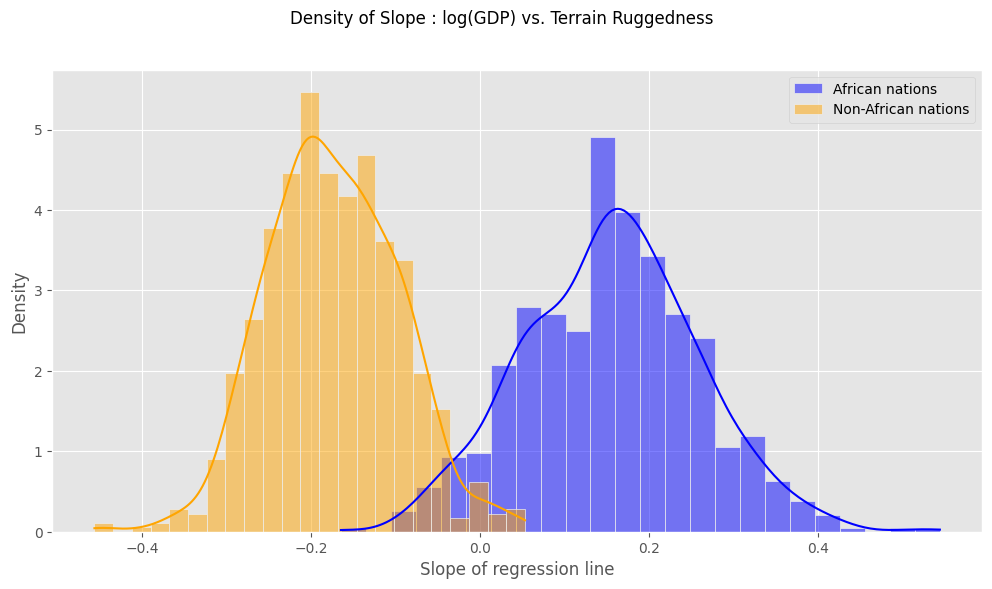

In [31]:
fig = plt.figure(figsize=(12, 6))
sns.histplot(gamma_within_africa.detach().cpu().numpy(), kde=True, stat="density", label="African nations", color="blue")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), kde=True, stat="density", label="Non-African nations", color="orange")
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

### Bayesian Model Evaluation with Posterior Predictive Checks

In [32]:
preds = pyro.infer.Predictive(reg_model, guide=mvg_guide, num_samples=800)
svi_samples = preds(is_cont_africa, ruggedness, log_gdp=None)
svi_gdp = svi_samples['obs']

In [33]:
predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": svi_gdp.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_gdp.kthvalue(int(len(svi_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_gdp.kthvalue(int(len(svi_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})

In [34]:
african_nations = predictions[predictions["cont_africa"] == 1].sort_values(by=["rugged"])
non_african_nations = predictions[predictions["cont_africa"] == 0].sort_values(by=["rugged"])

[Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 1.0, 'African Nations')]

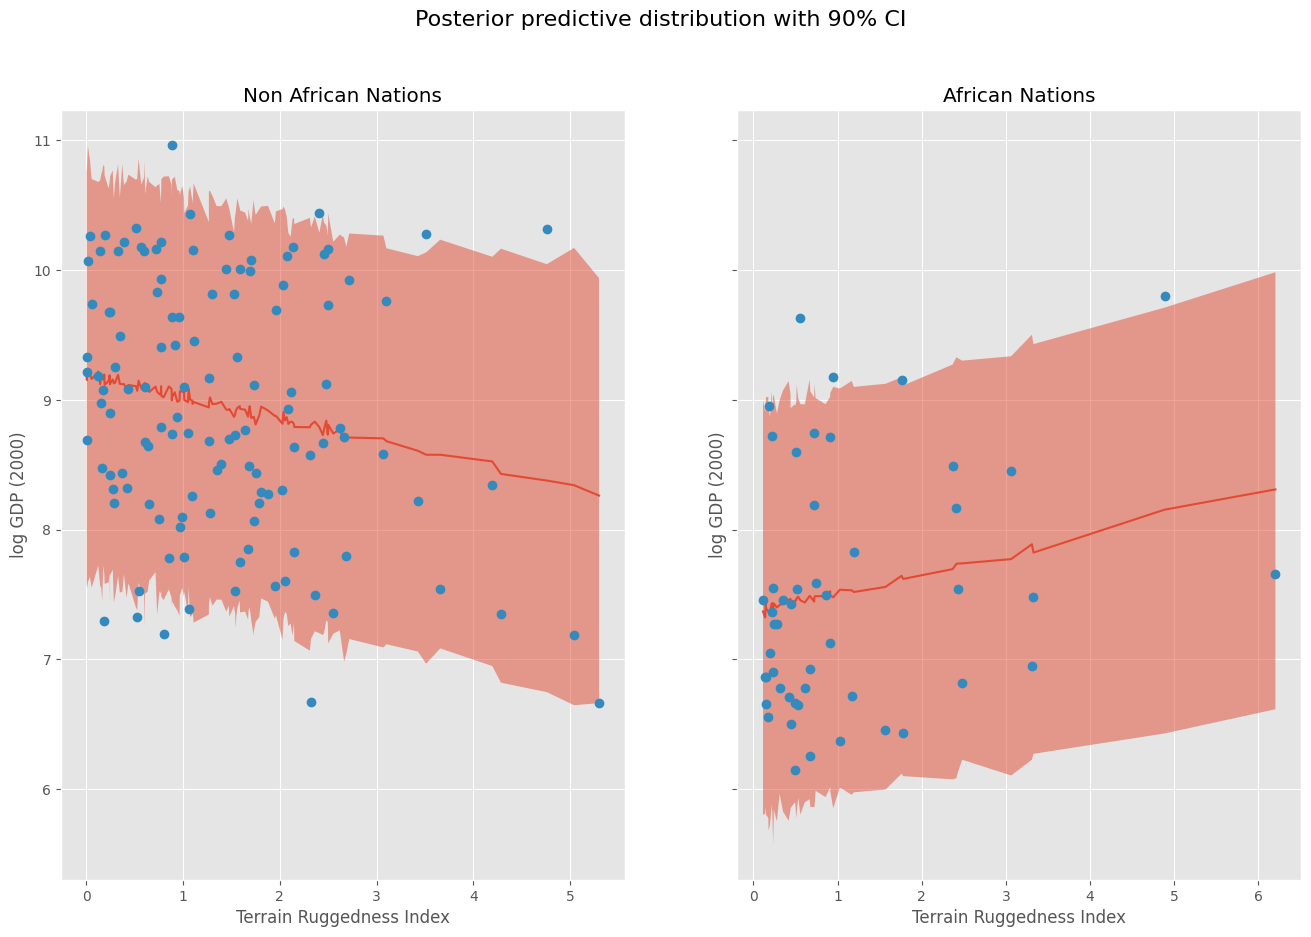

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(
                    non_african_nations["rugged"], 
                    non_african_nations["y_perc_5"], 
                    non_african_nations["y_perc_95"], 
                    alpha=0.5
                )
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")

ax[1].plot(african_nations["rugged"], african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"], african_nations["y_perc_5"], african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(african_nations["rugged"], african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations")


In [36]:
svi_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}



<AxesSubplot: >

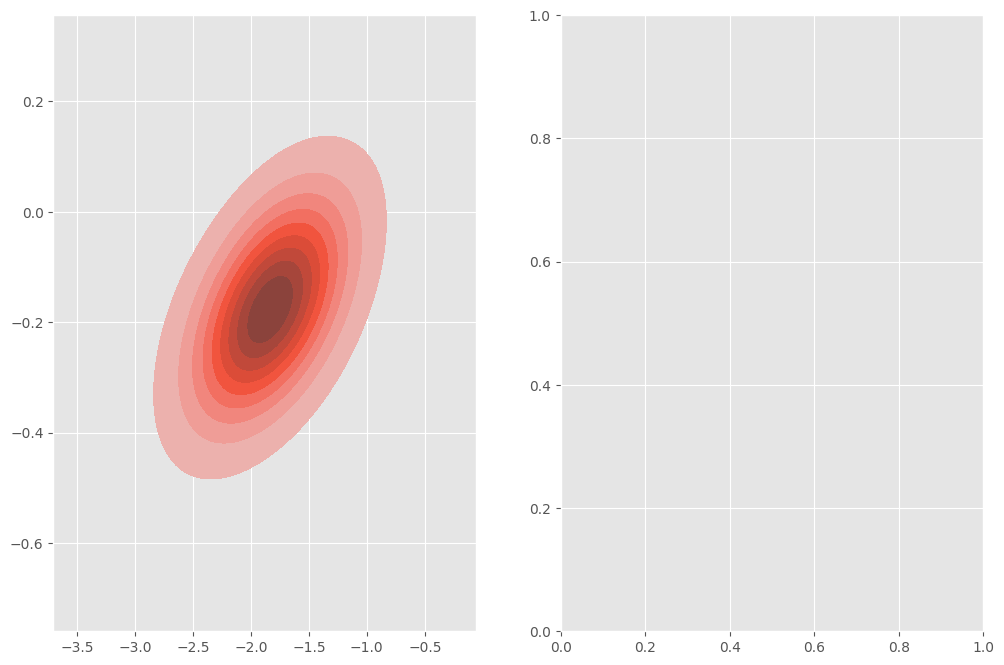

In [42]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

sns.kdeplot(x=svi_samples["beta_a"], y=svi_samples["beta_r"], ax=axs[0], fill=True ,bw_adjust=4 )